# Ford GoBike System Data
## by Murong (Sophie) Cui

## Investigation Overview

> Gobike completed close to 200 thousand rides in San Francisco in one month (Fed 2019), which shows us a great need of short/medium bike transportation. So firstly, we could look at the popularity of stations and paths that may could help making business decision like where to add a station or add more bikes at certain station.
Secondly, we could also take a look at the customer segmentation. We have some user feature like, age, gender, subscribed or not, in the program 'bike share for all' or not ...<br>
Then, it is interesting to draw insights from share-mobility over time. But since we only have one month data, it is still worthy to take a look at the trip frequency by day of the week, or the hour of the day, etc....<br>



## Dataset Overview
> This data set includes information about individual rides made
in a bike-sharing system covering the greater San Francisco
Bay area.Note that this dataset will require some data wrangling in
order to make it tidy for analysis.
There are 174,951 rows represting 174951 rides during Feb 2019 in Great San Francisco (San Francisco, Oakland, San Jose) and 15 columns

- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (Other; Male; Female)
- Year of Birth
- bike_share_for_all_trip, which tracks members who are enrolled in the Bike Share for All program for low-income residents.


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

import folium
from folium.plugins import MarkerCluster
from datetime import datetime
import missingno as msno

from PIL import Image, ImageDraw, ImageFont
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb


In [2]:
# load in the dataset into a pandas dataframe
gb = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# Data Cleaning 1. Correct data type
gb['start_time'] = pd.to_datetime(gb['start_time'])
gb['end_time'] = pd.to_datetime(gb['end_time'])

gb['start_station_id'] = gb['start_station_id'].astype('Int64')
gb['end_station_id'] = gb['end_station_id'].astype('Int64')
gb['bike_id'] = gb['bike_id'].astype('Int64')

gb['member_birth_year'] = gb['member_birth_year'].astype('Int64')

# Data Cleaning 2. missing values
gb = gb.dropna(subset = ['start_station_id'])
#gb.dropna(subset = ['start_station_id']).shape

# Data Cleaning 3. Erroneous value on `member_birth_year`
# gb = gb[gb.member_birth_year >= 1900] delet all the missing values
gb = gb.drop(gb[gb.member_birth_year < 1900].index)

In [4]:
# feature engineering
gb['hour'] = gb['start_time'].apply(lambda x: x.hour)

conditions = [(gb.start_station_latitude < 37.837769) & 
   (gb.start_station_latitude > 37.633183) & 
   (gb.start_station_longitude < -122.336283) &
   (gb.start_station_longitude > -122.603469),
             (gb.start_station_latitude < 37.457020) & 
   (gb.start_station_latitude > 37.221726) & 
   (gb.start_station_longitude < -121.718031) &
   (gb.start_station_longitude > -122.181992),
             (gb.start_station_latitude < 37.890247) & 
   (gb.start_station_latitude > 37.738964) & 
   (gb.start_station_longitude < -122.200436) &
   (gb.start_station_longitude > -122.356161)]

values = ['san_fran', 'san_jose', 'oakland']
gb['city'] = np.select(conditions, values)

gb['duration_min'] = round(gb['duration_sec']/60, 2)
gb['DoW'] = gb['start_time'].dt.dayofweek
gb['age'] = 2019 - gb['member_birth_year']
gb['age_group'] = pd\
.cut(gb.age, 20, right = True, precision = 0, include_lowest = True)

import math
def distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return round(d, 2)

gb['distance_km'] = gb\
.apply(lambda x: distance(x['start_station_latitude'], 
                          x['start_station_longitude'], 
                          x['end_station_latitude'], 
                          x['end_station_longitude']), axis = 1)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Geo Analysis

### Station
Yellow circle means net departures and blue circle means net arrival. Locations that have positive net departures in the morning rush hour 8am - 9am (left figure) have net arrivals in the evening rush hour 17pm - 18pm (right figure), likely matching the pattern that people going to work in the morning and back home evening. Also We could tell these are 3 main area in the greater SF area, San Francisco, Oakland, and San Jose. So we could add one more column to specific the area (San Francisco, Oakland, San Jose)
### Paths
The above are two graph plotting paths on the map, the left one is the paths on 8AM on Tuesday. And the right one is the paths on 17PM on Sunday. These is clear difference. The left shows At 8AM on Tuesday, a hight volume of path inbounding to the downtown San Francisco, Financial District, Downtown Oakland, Civic Center and Downtown San Jose. This is consistent with the station count geo plot before, indicating the rides are employed by morning commute. 
The right plot capturing rides on Sunday evening shows no high volume path. 

In [5]:
def arr_dep_count_by_time(select_day, select_hour): 

    temp1 = gb\
.groupby('start_station_id')\
.first()\
.loc[:, ['start_station_name', 'start_station_latitude', 'start_station_longitude']]

    temp2_start_count = gb[(gb.hour == select_hour) & gb.DoW.isin(select_day)]\
.groupby('start_station_id')\
.size()\
.to_frame('departure_count')

    temp3_end_count = gb[(gb.hour == select_hour) & gb.DoW.isin(select_day)]\
.groupby('end_station_id')\
.size()\
.to_frame('arrival_count')

    trip_count = temp1.join(temp2_start_count).join(temp3_end_count)

    trip_count['departure_count'] = np\
.where(trip_count['departure_count'].isnull(), 0, trip_count['departure_count'])

    trip_count['arrival_count'] = np\
.where(trip_count['arrival_count'].isnull(), 0, trip_count['arrival_count'])

    return trip_count

def plot_arr_dep(trip_count, zoom_start = 9.3):
    # draw the map canvas
    map_coords = [37.558639, -122.133339]
    folium_map = folium.Map(location = map_coords, 
                    zoom_start = zoom_start, 
                    tiles = 'cartodbpositron')
    for index, row in trip_count.iterrows():
    # calculate net departures
        net_departures = row['departure_count'] - row['arrival_count']
        popup_text = "Station: {} <br> Total Departures: {} <br> Total Arrivals: {} <br> Net Departures: {}"\
    .format(row['start_station_name'], row['departure_count'], row['arrival_count'], net_departures)
    # radius of circles
        radius = np.abs(net_departures)/5
    # choose the color of the marker
        if net_departures > 0:
            color = '#ffcc66'
        else:
            color = '#99ccff'
    # add marker
        marker = folium.CircleMarker(location = [row['start_station_latitude'], row['start_station_longitude']],
                       radius = radius,
                       color = color,
                       popup = popup_text,
                       fill = True)
        marker.add_to(folium_map)
    return folium_map

arr_dep_1_8 = plot_arr_dep(arr_dep_count_by_time([1], 8))
arr_dep_1_17 = plot_arr_dep(arr_dep_count_by_time([1], 17))

from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(arr_dep_1_8.get_root().render().replace('"', '&quot;'),500,500,
                   arr_dep_1_17.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

In [6]:
def path_count_by_time(select_day, select_hour):
    # declare the coordinates by stations
    locations = gb\
    .groupby('start_station_id')\
    .agg({'start_station_latitude': 'mean', 
                                    'start_station_longitude': 'mean',
                                    'start_station_name': 'first'})
    # (start_station_id, end_station_id) is a path_id
    gb['path_id'] = [(id1, id2) for id1, id2 in zip (gb['start_station_id'], gb['end_station_id'])]
    # select by hour and then group by path_id
    paths = gb[(gb.hour == select_hour) & (gb.DoW.isin(select_day)) ]\
    .groupby('path_id')\
    .size()\
    .to_frame('trip_counts')
    # select only paths with more than min_counts (X) trips default = 0
    paths = paths[paths["trip_counts"]>0]
    paths["start_station_id"] = paths.index.map(lambda x:x[0])
    paths["end_station_id"] = paths.index.map(lambda x:x[1])
    paths = paths[paths["start_station_id"]!=paths["end_station_id"]]
    
    # join latitude and longitude into the new table
    paths = paths.join(locations, on='start_station_id')
    locations.columns = ['end_station_latitude', 'end_station_longitude', 'end_station_name']
    paths = paths.join(locations, on='end_station_id')
    paths.index = range(len(paths))
    return paths


def plot_path_count(paths, zoom_start = 9.3):
    folium_map = folium.Map(location=[37.558639, -122.133339],
                        zoom_start=9.3,
                        tiles = 'cartodbpositron')
    for i, row in paths.iterrows():
        line = folium.PolyLine(locations = [(row['start_station_latitude'], row['start_station_longitude']),
                                 (row['end_station_latitude'], row['end_station_longitude'])],
                           opacity = np.log(row['trip_counts'])/2, 
                           #smooth_factor = row['trip_counts']/20, 
                           weight = np.log(row['trip_counts'])/2, 
                          color = '#0066cc')
        line.add_to(folium_map)
        popup_text = "Station: {} <br> Total Rides departed from here: {} "\
        .format(row['start_station_name'], row['trip_counts'])
        marker = folium.CircleMarker(location = [row['start_station_latitude'], row['start_station_longitude']],
                               radius = 1,
                               color = '#3366cc',
                               popup = popup_text)
        marker.add_to(folium_map)
    return folium_map
path_1_8 = plot_path_count(path_count_by_time([1], 8))
path_6_17 = plot_path_count(path_count_by_time([6], 17))
from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(path_1_8.get_root().render().replace('"', '&quot;'),500,500,
                   path_6_17.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

## Univaraite Exploration

### User segmentation

It is tricky to look at user segmentation, since we dont have user id. All the user information is based on the rides, which leads bias due the same user having multiple rides. Therefore all the insights about user segmentation in this pics is based on the total number of rides. We could say among certain 183214 of rides, 163414 rides are made by Subscribers and 19800 made by Customers, which means almost 90% ride were taken by subscribers, in other words, almost 9 out of 10 rides are part of a subscription package. However, it is not saying the actual ratio of between subscriber and casual rider, since the subscriber VS Casual rider ratio should be $\frac{\text{# of subscriber user_id}}{\text{# of casual user_id}}$<br> As for member gender, despite 8263 rides not containing information of user gender, 130500 rides out of 174951 were taken by males, and 40804 rides are taken by female (Only one in hour ride taken by female). It is fair to assume that the male VS female ratio is not close as well as female are more concerned about cosmetic side-effect and mess-up hair during riding. And for Bike Share for All program for low-income residents, there are 17346 out of 183214, around 9% rides are part of bike share for all program. 

### Number of rides over time
We look at the trip counts over 2 dimensions, day of week and hour of day. I plot the number of rides over day of week and we could tell that the number of trips on weekdays is around double than the number over the weekends. It seems like that more need to ride short commute or fulfill the last mile to their offices or destinations on weekdays.
And for hour of day, we could tell the two peaks around 8 o'clock and 17 o'clock, which indicates that the large needs around the morning and evening rush hour. 

### Distributions of trip duration and trip distance
Both trip duration and trip distance are right skewed, so I did log transformation to both of them. After transformation the distributions goes to normal.

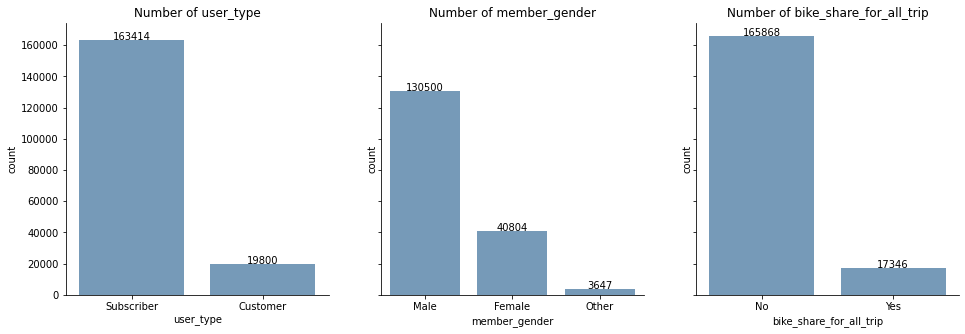

In [7]:
# user segmentation:
# user_type, member_gender, bike_share_for_all_trip,
sb.set_style()
# sb.despine()

fig, axes = plt.subplots(1, 3, figsize = (16, 5), sharey=True)
c = ['user_type', 'member_gender', 'bike_share_for_all_trip']
for i, user_seg in enumerate(c):
    sb.countplot(data = gb, 
                 x = user_seg, 
                 ax=axes[i], 
                 order = gb[user_seg].value_counts().index, 
                 alpha = 0.8, color = 'steelblue')
    for d, p in enumerate(axes[i].patches):
        height = p.get_height()
        axes[i].text(p.get_x()+p.get_width()/2., height + 0.1, gb[user_seg].value_counts()[d],ha="center")
    
    axes[i].set_title('Number of {}'.format(user_seg))
    axes[i].set_xlabel(user_seg)
    sb.despine()

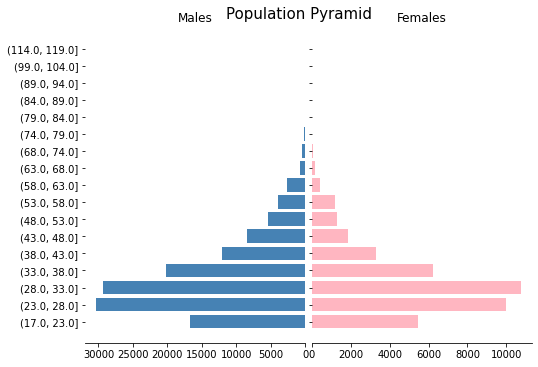

In [9]:
temp2 = gb.groupby(['age_group', 'member_gender']).size().to_frame('size').reset_index()
temp2 = temp2.pivot(index = 'age_group', columns = 'member_gender', values = 'size')
#define x and y limits
y = range(0, len(temp2))
x_male = temp2['Male']
x_female = temp2['Female']

#define plot parameters
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 6))

#specify background color and plot title
plt.figtext(.5,.9,"Population Pyramid ", fontsize=15, ha='center')
    
#define male and female bars
axes[0].barh(y, x_male, align='center', color='steelblue')
axes[0].set(title='Males')
axes[1].barh(y, x_female, align='center', color='lightpink')
axes[1].set(title='Females')

#adjust grid parameters and specify labels for y-axis
#axes[1].grid()
axes[0].set(yticks=y, yticklabels=temp2.index)
axes[0].invert_xaxis()
#axes[0].grid()

#display plot
plt.subplots_adjust(bottom=0.15, wspace=0.03)
sb.despine(left = True)

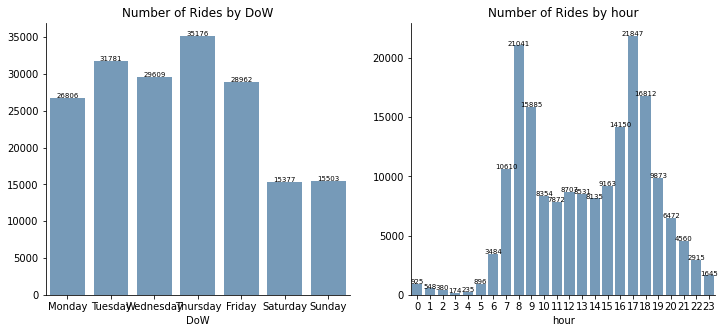

In [10]:
def bar_plot(feature):
    temp1 = gb[feature].value_counts().sort_index()
    x = np.arange(len(temp1.index))
    g = sb.barplot(x = temp1.index, 
                  y = temp1.values,
                  alpha = 0.8,
                  color = 'steelblue')
    for d, p in enumerate(g.patches):
        height = p.get_height()
        g.text(p.get_x() + p.get_width()/2., height + 0.1, temp1[d], ha='center', size = 7)
    g.set_xticks(x)
    g.set_xticklabels(temp1.index)
    g.set_title('Number of Rides by {}'.format(feature))
    g.set_xlabel('{}'.format(feature))
    sb.despine()
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
axes[0] = bar_plot('DoW')
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.subplot(1,2,2)
axes[1] = bar_plot('hour')

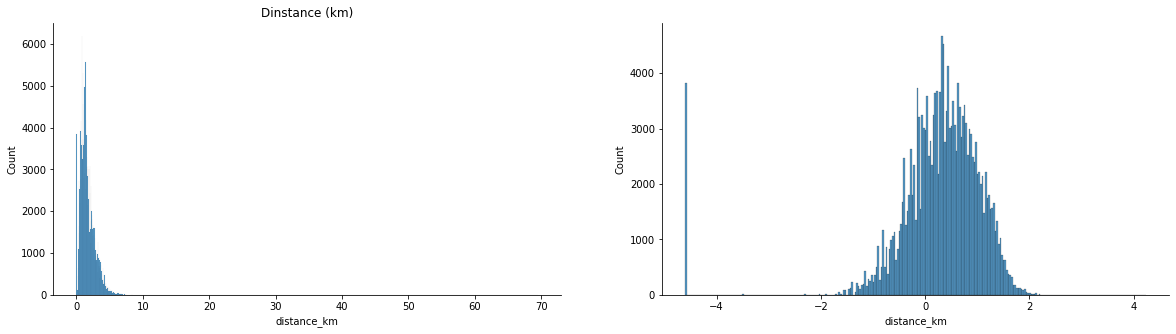

In [15]:
plt.figure(figsize = [20, 5])
plt.subplot(1,2,1)
sb.histplot(gb['distance_km']);
plt.title('Dinstance (km)')
sb.despine()

plt.subplot(1,2,2)
# log10 normalization
sb.histplot(np.log(gb.distance_km + 0.01));
sb.despine();

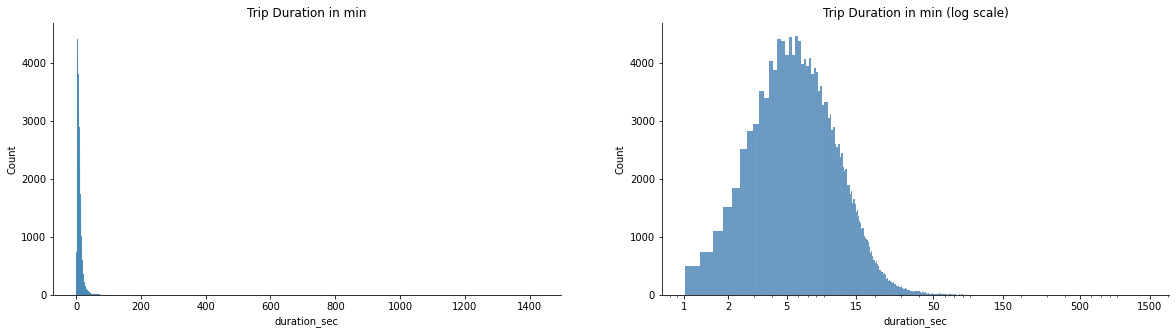

In [14]:
plt.figure(figsize = [20, 5])
plt.subplot(1,2,1)
sb.histplot(gb.duration_sec/60);
plt.title('Trip Duration in min')
sb.despine()

plt.subplot(1,2,2)
# Log10 normalization
bins = len(10**np.arange(1, 5+0.01, 0.01))
ticks = [1, 2, 5, 15, 50, 150, 500,1500]
labels = [v for v in ticks ]
sb.histplot(gb.duration_sec/60, alpha = 0.8, color = 'steelblue');
#g.set_xlabel('log')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.title('Trip Duration in min (log scale)')
sb.despine()

## Bivariate Exploration

### Number of rides over time (customers vs subscribers)
I plot heatmaps, the heatmaps are capturing the number of rides over hour of day and day of week. When we look at the subscriber plot (right plot), there is a clear trajectory of rides taken by subscribers over time, which is that subscribers are taking rides on morning and evening rush hour on weekday. And the left plot is only for customers, same as the subscribers, customers take rides for weekday commuting. and interestingly, customers also have more need on weekend, which indicated that rids taken by customers on weekend may not be pre-scheduled. 

### user age VS distance and duration
I draw two line plots. The left plot is age vs average trip distance and the right plot is age VS average trip duration. Between 20 year age and 60 year ago, the average distance is relatively stable, and after 60 year ago, the trip distance and trip duration have large variance. 

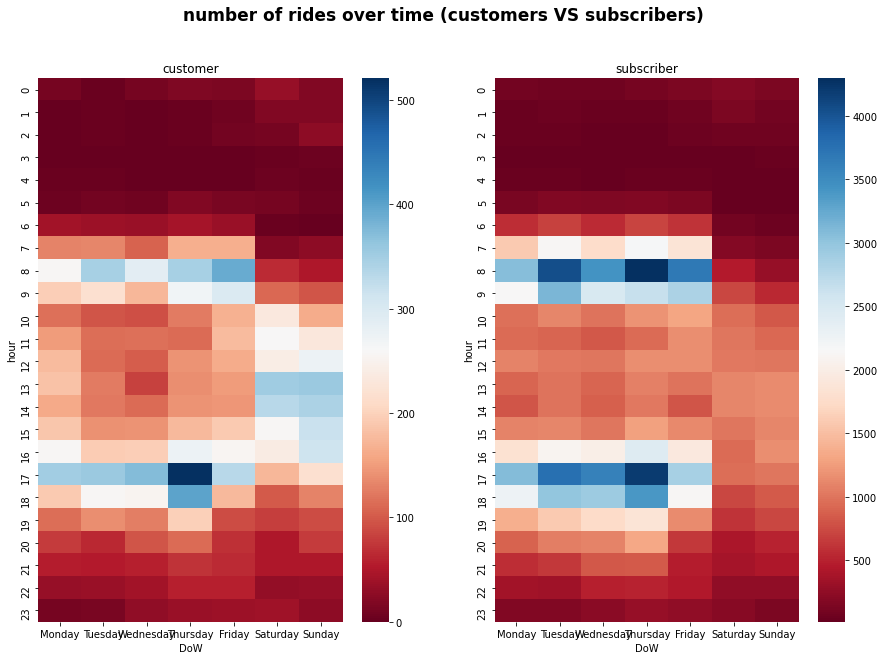

In [17]:
temp3_cus = gb[gb.user_type == 'Customer'].groupby(['DoW', 'hour']).size().to_frame('size').reset_index()
temp3_cus = temp3_cus.pivot(index = 'hour', columns = 'DoW', values = 'size').fillna(0)

temp3_sub = gb[gb.user_type == 'Subscriber'].groupby(['DoW', 'hour']).size().to_frame('size').reset_index()
temp3_sub = temp3_sub.pivot(index = 'hour', columns = 'DoW', values = 'size').fillna(0)

plt.figure(figsize = (15, 10))
plt.suptitle('number of rides over time (customers VS subscribers)', 
             fontsize = 17, 
             fontweight = 'bold');
plt.subplot(1,2,1)
sb.heatmap(temp3_cus, cmap='RdBu');
plt.xticks(np.arange(0.5, 7.5), 
           ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.title('customer');

plt.subplot(1,2,2)
sb.heatmap(temp3_sub, cmap='RdBu');
plt.xticks(np.arange(0.5, 7.5), 
           ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.title('subscriber');

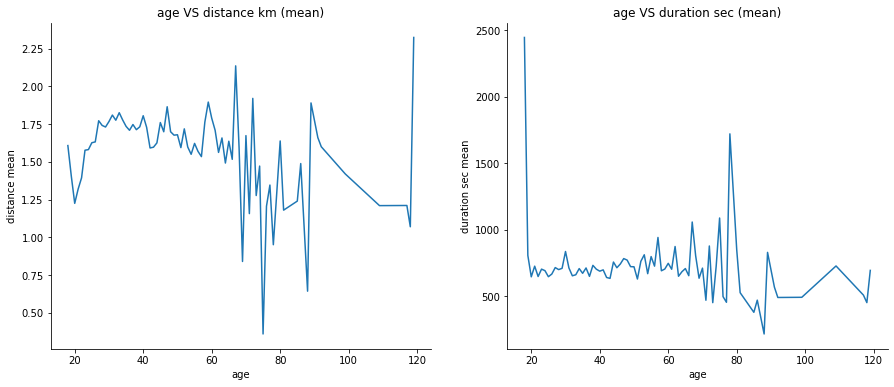

In [18]:
temp4_dis = gb.groupby(['age'])['distance_km'].mean().to_frame('mean').reset_index()
temp4_dur = gb.groupby(['age'])['duration_sec'].mean().to_frame('mean').reset_index()
plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
sb.lineplot(x = 'age', y='mean',  data=temp4_dis);
plt.ylabel('distance mean')
plt.title('age VS distance km (mean)')
sb.despine()

plt.subplot(1,2,2)
sb.lineplot(x = 'age', y='mean',  data=temp4_dur);
plt.ylabel('duration sec mean')
plt.title('age VS duration sec (mean)')
sb.despine()


## Multivariate Exploration

### Volume over time between cities
When Adding the cities (San Francisco, San Jose, Oakland) into the number of rides over time, We could tell all three cities shows the similar trends, a high volume on weekday commute rush hour and weekend afternoon. Among the cities, San Francisco has the highest sharing bike needs, and followed by Oakland and then San Jose.

### Detailed user segmentation VS trip distance and trip duration
For all four plots, it is suspicious that the member gender of other shows some usual thing for all plots. It is worthy to investigate it if we have more data. Besides, overall subscribers is generally taking rides with more distance and more duration. And there is no significant difference between male and female regarding average trip duration and average trip duration.

<Figure size 2160x720 with 0 Axes>

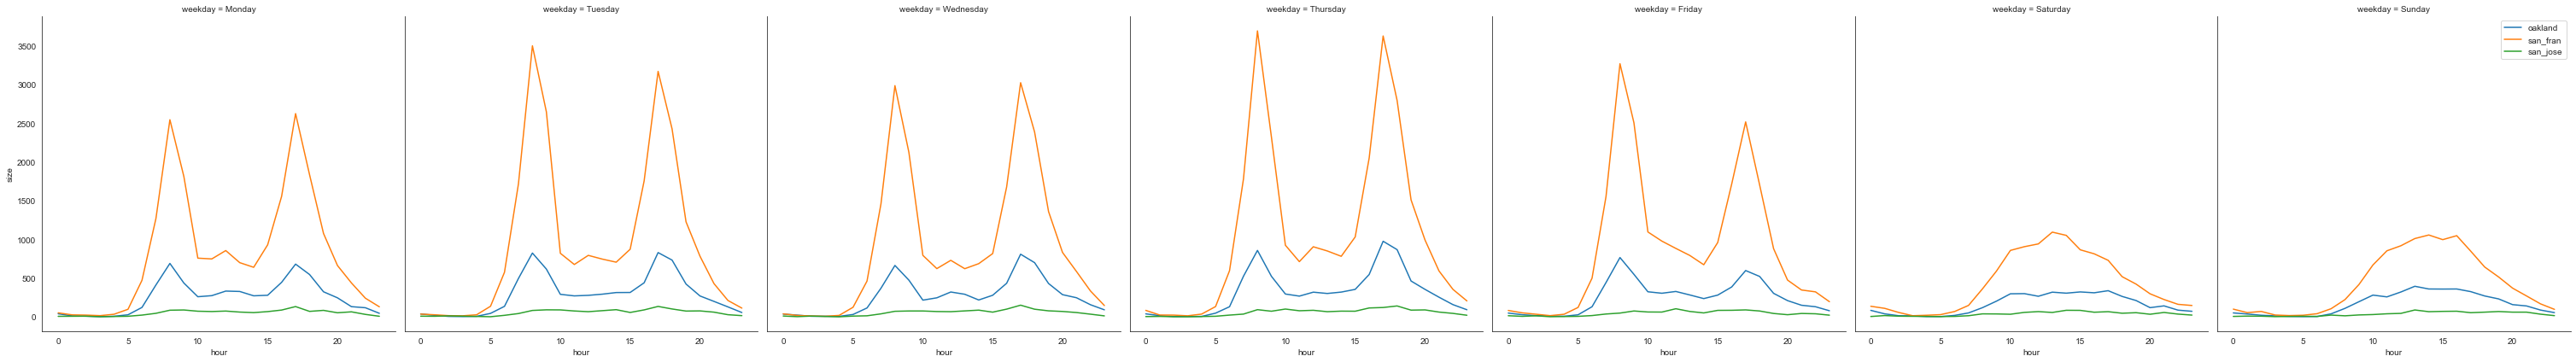

In [20]:
plt.figure(figsize = (30, 10))
temp6 = gb.groupby(['city', 'hour', 'DoW']).size().to_frame('size').reset_index()
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
temp6['weekday'] = temp6['DoW'].map(dayOfWeek)
col_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sb.set_style("white");
ax = sb.FacetGrid(temp6, col="weekday", col_wrap=7, height=6, col_order=col_order, hue = 'city');
ax.map(sb.lineplot, "hour", "size");
plt.legend();

# plt.savefig('pic/multi1.png')

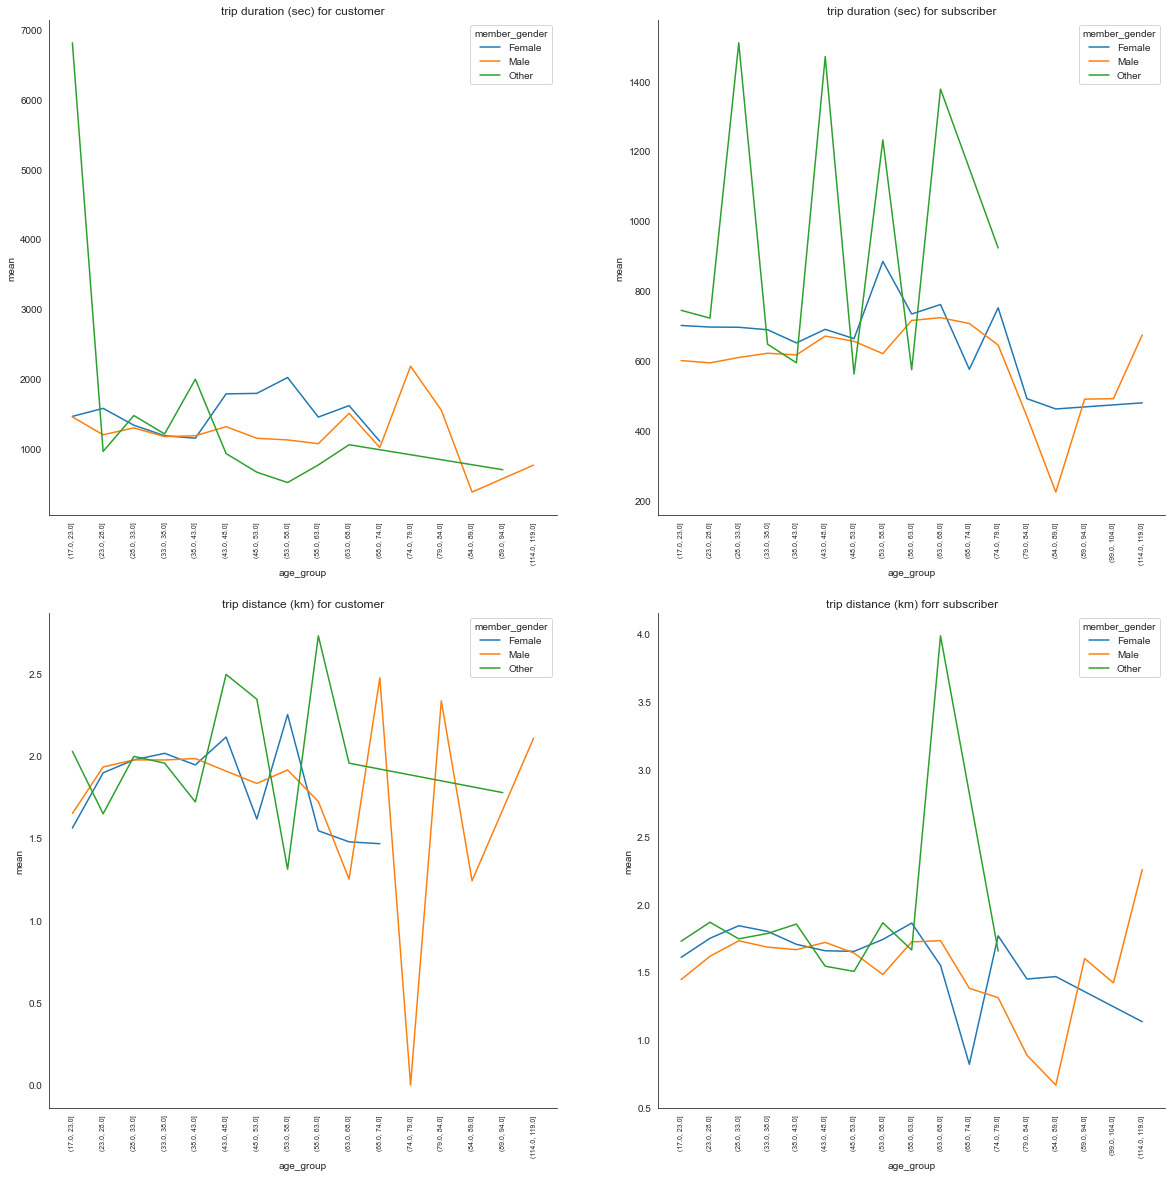

In [22]:


temp7_sub = gb[gb.user_type == 'Subscriber']\
.groupby(['age_group', 'member_gender'])['distance_km']\
.mean().to_frame('mean').reset_index()

temp7_cus = gb[gb.user_type == 'Customer']\
.groupby(['age_group', 'member_gender'])['distance_km']\
.mean().to_frame('mean').reset_index()

temp8_sub = gb[gb.user_type == 'Subscriber']\
.groupby(['age_group', 'member_gender'])['duration_sec']\
.mean().to_frame('mean').reset_index()

temp8_cus = gb[gb.user_type == 'Customer']\
.groupby(['age_group', 'member_gender'])['duration_sec']\
.mean().to_frame('mean').reset_index()
plt.figure(figsize = (20, 20))

plt.subplot(2,2,1)
sb.lineplot(x = temp8_cus['age_group'].astype(str), y='mean', hue = 'member_gender', data = temp8_cus)
plt.xticks(rotation = 90, fontsize = 7)
plt.title('trip duration (sec) for customer')
sb.despine()

plt.subplot(2,2,2)
sb.lineplot(x = temp8_sub['age_group'].astype(str), y='mean', hue = 'member_gender', data = temp8_sub)
plt.xticks(rotation = 90, fontsize = 7)
plt.title('trip duration (sec) for subscriber')
sb.despine()

plt.subplot(2,2,3)
sb.lineplot(x = temp7_cus['age_group'].astype(str), y='mean', hue = 'member_gender', data = temp7_cus)
plt.xticks(rotation = 90, fontsize = 7)
plt.title('trip distance (km) for customer')
sb.despine()

plt.subplot(2,2,4)
sb.lineplot(x = temp7_sub['age_group'].astype(str), y='mean', hue = 'member_gender', data = temp7_sub)
plt.xticks(rotation = 90, fontsize = 7)
plt.title('trip distance (km) forr subscriber')
sb.despine()

#plt.savefig('pic/multi2.png')

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!